In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from 指标计算 import *

plt.rcParams['font.sans-serif']=['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus']=False   # 解决保存图像是负号'-'显示为方块的问题

## LSTM预测

In [3]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 定义特征和目标值
features = ['open', 'high', 'low', 'close', 'volume', 'open_interest', 'turnover']
target = 'next_close'
allField = features + [target]
# 数据读取
data = cal_main('../DB/GFEX.csv', 'SI')
# 使用第二天的close值作为，每个样本的目标值
data['next_close'] = data['close'].shift(-1)
data.drop(data.index[-1], inplace=True)
# 对每一列数据进行标准化
scaler = StandardScaler()
data[allField] = scaler.fit_transform(data[allField])
# 划分数据集为训练集和测试集
train_size = int(len(data) * 0.75)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]
# 建立滞后矩阵，转为LSTM需要的格式
def create_data(Atemp: pd.DataFrame, lookback=1):
    temp = Atemp.copy()
    temp = temp.reset_index()
    X = []
    Y = []
    for i in range(len(temp)-(lookback-1)):
        X.append(temp.loc[i:(i+lookback-1), features])
        Y.append(temp.loc[(i+lookback-1), target])
    return np.array(X), np.array(Y)
# 创建合适形状数据集
lookback = 1
X_train, Y_train = create_data(train_data, lookback)
X_test, Y_test = create_data(test_data, lookback)

In [4]:
# 定义模型
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(lookback, len(features))))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# 训练模型
model.fit(X_train, Y_train, epochs=100, batch_size=5, verbose=1)
# 预测训练集和测试集
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

Epoch 1/100
12/12 [==============================] - 2s 3ms/step - loss: 0.5450
Epoch 2/100
12/12 [==============================] - 0s 2ms/step - loss: 0.4644
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 0.3526
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 0.2573
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 0.1564
Epoch 6/100
12/12 [==============================] - 0s 3ms/step - loss: 0.1531
Epoch 7/100
12/12 [==============================] - 0s 3ms/step - loss: 0.1206
Epoch 8/100
12/12 [==============================] - 0s 3ms/step - loss: 0.1130
Epoch 9/100
12/12 [==============================] - 0s 2ms/step - loss: 0.1165
Epoch 10/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0940
Epoch 11/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0850
Epoch 12/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0886
Epoch 13/100
12/12 [=================

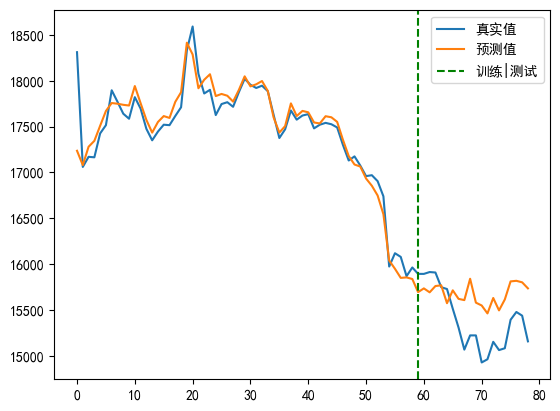

In [6]:
# 反标准化还原数据
dataNew = data.copy()
preNew = data.copy()


# # 对于预测部分损耗，填NaN
# preNew.loc[0:lookback-1, target] = np.nan
# preNew.loc[train_size:train_size+lookback-2, target] = np.nan
# # 把预测结果填入新表
# preNew.loc[lookback-1:train_size-1, target] = train_predict
# preNew.loc[train_size+lookback-1:, target] = test_predict

pre = np.vstack((train_predict, test_predict))
preNew['next_close'] = pre

# 还原数据
dataNew[allField] = scaler.inverse_transform(dataNew[allField])
preNew[allField] = scaler.inverse_transform(preNew[allField])
# 画图
plt.plot(dataNew['close'], label='真实值')
plt.plot(preNew['next_close'], label='预测值')
plt.axvline(train_size, linestyle='--', color='green', label='训练|测试')
plt.legend()

## 范例参考

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 准备数据
data = np.array([[110, 220, 330],
                 [120, 230, 340],
                 [130, 240, 350],
                 [140, 250, 360],
                 [150, 260, 370],
                 [160, 270, 380],
                 [170, 280, 390],
                 [180, 290, 3100],
                 [190, 2100, 3110],
                 [1100, 2110, 3120]])

# # 将数据缩放到0到1之间
scaled_data = data
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(data)

# 创建输入和输出数据
lookback = 3  # 时间步长，用于构建输入序列
X = []
y = []
for i in range(len(scaled_data) - lookback):
    X.append(scaled_data[i:i+lookback, :2])
    y.append(scaled_data[i+lookback, 2])
X = np.array(X)
y = np.array(y)

# 将数据集拆分为训练集和测试集
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 将输入数据重塑为 LSTM 模型所需的形状 (样本数, 时间步长, 特征数)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 2))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 2))

# 构建 LSTM 模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(lookback, 2)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)

# 进行预测
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 将预测结果反缩放回原始范围
# train_predict = scaler.inverse_transform(train_predict)
# y_train = scaler.inverse_transform([y_train])
# test_predict = scaler.inverse_transform(test_predict)
# y_test = scaler.inverse_transform([y_test])

print("训练集预测结果：")
print(train_predict)
print("测试集预测结果：")
print(test_predict)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 导入数据
df = cal_main('../DB/GFEX.csv', 'SI')
all = ['open', 'high', 'low', 'close', 'volume', 'open_interest', 'turnover', 'next_close']
# 使用第二天的close值作为，每个样本的目标值
df['next_close'] = df['close'].shift(-1)
df.drop(df.index[-1], inplace=True)
df = df[all]
# 特征和目标值
features = ['open', 'high', 'low', 'close', 'volume', 'open_interest', 'turnover']
target = 'next_close'

# 特征缩放
scaler = MinMaxScaler()
df[all] = scaler.fit_transform(df[all])

# 准备数据集
X = []
y = []
for i in range(6, len(df)):
    X.append(df[features][i-6:i])
    y.append(df[target][i])
X, y = np.array(X), np.array(y)

# 划分训练集和测试集
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# 定义模型
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(6, 7)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# 训练模型
model.fit(X_train, y_train, epochs=50, batch_size=10)

# 预测训练集和测试集
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反向缩放
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
train_predict = scaler.inverse_transform(train_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)

# 绘制训练集真实值和预测值
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='true')
plt.plot(train_predict, label='pred')
plt.title('Training Set: True vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# 绘制测试集真实值和预测值
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='true')
plt.plot(test_predict, label='pred')
plt.title('Test Set: True vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.show()


## 修改